# **Visualisation notebook**

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'c:\\Users\\ryan_\\VS-code-projects\\CreditCardChurn\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\ryan_\\VS-code-projects\\CreditCardChurn'

### Analytical Scope

This project uses descriptive analytics to ensure transparency,
interpretability, and accessibility of insights for business stakeholders.
Predictive modelling was intentionally excluded to prioritise
explainable behavioural patterns over probabilistic forecasts.


# Hypothesis 1 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

df = pd.read_csv("dataFiles/cleanData/cleaned_credit_card_churn_data.csv")
df.head(2)
df.tail(2)

,Clientnum,AttritionFlag,CustomerAge,Gender,DependentCount,EducationLevel,MaritalStatus,IncomeCategory,CardCategory,MonthsOnBook,...,AvgUtilizationRatio,ChurnFlag,GenderEnc,IncomeCatEnc,EducationLevelEnc,MaritalStatusEnc,CardCategoryEnc,AvgTransactionValue,Inactive3plusFlag,UtilizationBand
10125,717406983,Attrited Customer,30,M,2,Graduate,Unknown,$40K - $60K,Blue,36,...,0.000,1,1,1.0,2,3,0,135.403226,1,0
10126,714337233,Attrited Customer,43,F,2,Graduate,Married,Less than $40K,Silver,25,...,0.189,1,0,0.0,2,1,3,168.754098,0,0-0.25


---

## Hypothesis 1 — Engagement and Inactivity

### Business Question
Are customers with lower engagement (higher inactivity and fewer product relationships) more likely to churn?

### Hypothesis
Customers with **higher inactivity** (Months_Inactive_12_mon) and **lower relationship count**
(Total_Relationship_Count) are more likely to churn.

### Measures Used
- **Churn outcome:** `ChurnFlag` (1 = churned, 0 = existing)
- **Inactivity:** `MonthsInactive12Mon`
- **Engagement proxy:** `TotalRelationshipCount`

### Analytical Approach
I compare churn rates and distributions between churned vs existing customers:
1. Compare inactivity distributions by churn status (boxplot + summary statistics).
2. Compare churn rate across different relationship counts (bar chart + rate table).


In [5]:
#sanity check to confirm columns of interest are present
required_cols = ["ChurnFlag", "AttritionFlag", "MonthsInactive12Mon", "TotalRelationshipCount"]
missing = [c for c in required_cols if c not in df.columns] #changed to not in to lessen non critical outputs on notebook
print("Missing columns:", missing)


Missing columns: []


## Evidence 1: Inactivity vs churn (Chart + stats)

In [6]:
inactivity_summary = (
    df.groupby("AttritionFlag")["MonthsInactive12Mon"]
      .agg(count="count", mean="mean", median="median", min="min", max="max")
      .round(2)
)
inactivity_summary


,count,mean,median,min,max
AttritionFlag,,,,,
Attrited Customer,1627,2.69,3.0,0,6
Existing Customer,8500,2.27,2.0,0,6


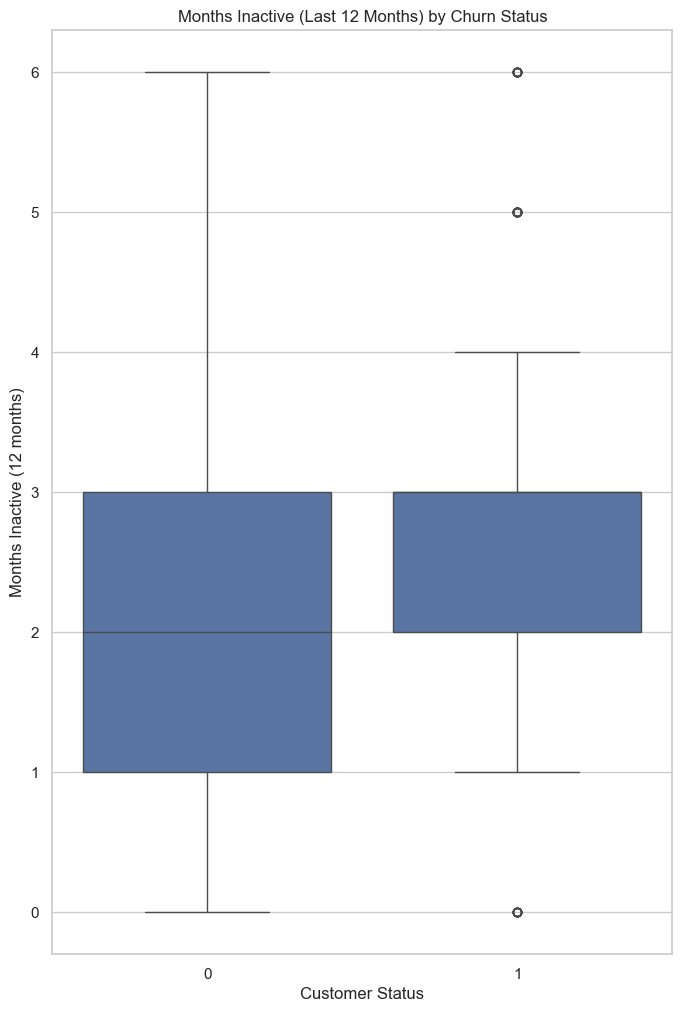

In [7]:
plt.figure(figsize=(8, 12))
sns.boxplot(data=df, x="ChurnFlag", y="MonthsInactive12Mon")
plt.title("Months Inactive (Last 12 Months) by Churn Status")
plt.xlabel("Customer Status")
plt.ylabel("Months Inactive (12 months)")
plt.show()


---

## Key Finding

### Evidence A — Inactivity vs Churn

**What I expected:**  
Customers who churn would exhibit higher levels of inactivity
compared to customers who remain with the bank.

**What the data shows:**  
- Churned customers have a higher average number of inactive months
  (mean = 2.69) compared to existing customers (mean = 2.27).
- The median inactivity for churned customers is **3 months**,
  compared to **2 months** for existing customers.
- While both groups share the same minimum and maximum inactivity values,
  the distribution for churned customers is shifted toward higher inactivity.

**Interpretation:**  
Higher customer inactivity is associated with an increased likelihood of churn,
supporting the view that disengagement is an early warning signal for attrition.


## Evidence 2: Relationship count vs churn (rates + chart)

In [8]:
churn_by_relationship = (
    df.groupby("TotalRelationshipCount")["ChurnFlag"]
      .agg(churn_rate="mean", customers="count")
      .reset_index()
)
churn_by_relationship["churnratepct"] = (churn_by_relationship["churn_rate"] * 100).round(2)
churn_by_relationship.sort_values("TotalRelationshipCount")


,TotalRelationshipCount,churn_rate,customers,churnratepct
0,1,0.256044,910,25.60
1,2,0.278359,1243,27.84
2,3,0.173536,2305,17.35
3,4,0.117678,1912,11.77
4,5,0.120042,1891,12.00
5,6,0.105038,1866,10.50


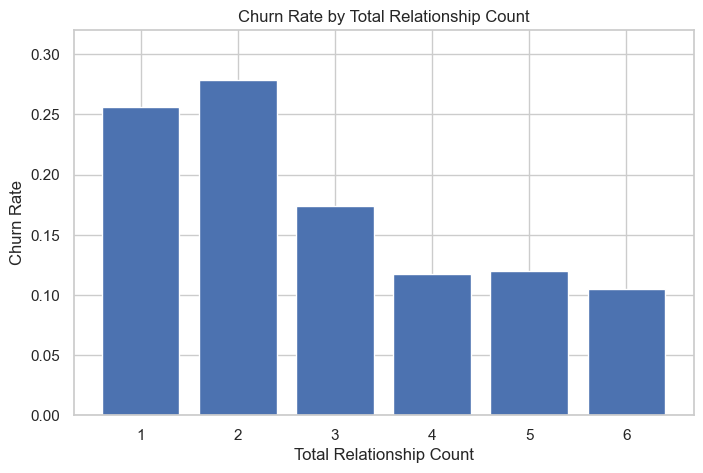

In [9]:
churn_rate_series = (
    df.groupby("TotalRelationshipCount")["ChurnFlag"]
      .mean()
      .sort_index()
)

plt.figure(figsize=(8, 5))
plt.bar(churn_rate_series.index.astype(str), churn_rate_series.values)
plt.title("Churn Rate by Total Relationship Count")
plt.xlabel("Total Relationship Count")
plt.ylabel("Churn Rate")
plt.ylim(0, churn_rate_series.max() * 1.15)
plt.show()


### Evidence B — Relationship Count vs Churn Rate

**What I expected:**  
Customers with fewer product relationships would exhibit higher churn rates,
while customers with more relationships would show greater retention.

**What the data shows:**  
- Customers with **1–2 relationships** show the highest churn rates
  (25.6% and 27.8% respectively).
- A substantial reduction in churn is observed once customers hold **3 or more relationships**.
- Customers with **6 relationships** exhibit the lowest churn rate (10.5%).
- Overall, churn rates decline as the total relationship count increases.

**Interpretation:**  
Higher product engagement, measured by total relationship count,
is associated with lower churn risk.
Customers with multiple relationships appear more embedded in the bank’s ecosystem,
making them less likely to leave.


### Conclusion — Hypothesis 1

The results support Hypothesis 1.
Customers who churn tend to be less engaged, showing both higher inactivity
and fewer product relationships.

While churn among customers with two relationships is slightly higher than those with one,
the overall trend demonstrates a clear reduction in churn
as relationship count increases beyond two.

### Business Implications
- Customers with **1–2 relationships** represent a high-risk churn segment
  and should be prioritised for early engagement initiatives.
- Encouraging customers to adopt additional products
  may strengthen retention by increasing overall engagement.
- Relationship count can be used as a simple, interpretable
  early-warning indicator for churn risk.

### Limitations
This analysis is descriptive and does not establish causality.
Additional behavioural and external factors not present in the dataset
may also influence churn outcomes.


---

# Hypothesis 2 

## Hypothesis 2 — Tenure and Churn

### Business Question
Are customers with shorter tenure (fewer months on book) more likely to churn?

### Hypothesis
Customers with shorter tenure (`MonthsOnBook`) are more likely to churn than long-standing customers.

### Measures Used
- **Churn outcome:** `ChurnFlag` (1 = churned, 0 = existing)
- **Tenure:** `MonthsOnBook`

### Analytical Approach
1. Compare tenure distributions between churned and existing customers (histogram + summary statistics).
2. Segment tenure into bands and compare churn rate across bands (bar chart + churn-rate table).
* Tenure was analysed both as a continuous variable and in discrete bands to identify potential non-linear churn patterns across the customer lifecycle.


In [10]:
#getting tenure summary stats 
tenure_summary = (
    df.groupby("AttritionFlag")["MonthsOnBook"]
      .agg(count="count", mean="mean", median="median", min="min", max="max")
      .round(2)
)
tenure_summary


,count,mean,median,min,max
AttritionFlag,,,,,
Attrited Customer,1627,36.18,36.0,13,56
Existing Customer,8500,35.88,36.0,13,56


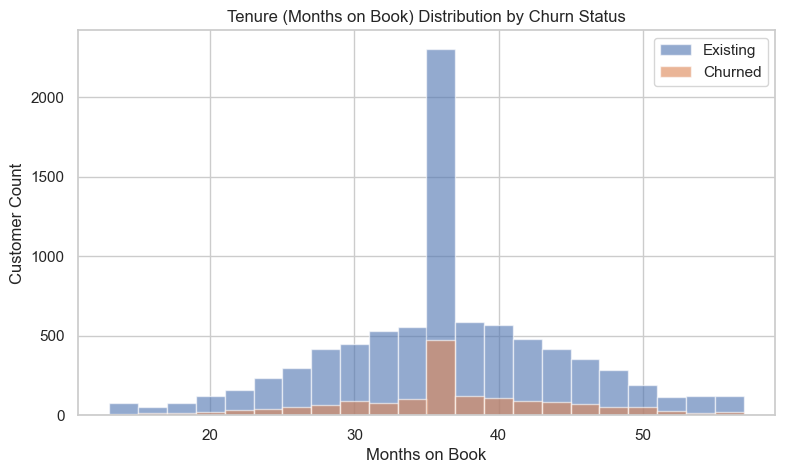

In [11]:
plt.figure(figsize=(9, 5))

existing = df.loc[df["ChurnFlag"] == 0, "MonthsOnBook"]
churned  = df.loc[df["ChurnFlag"] == 1, "MonthsOnBook"]

# Use consistent bins for comparability
bins = np.arange(df["MonthsOnBook"].min(), df["MonthsOnBook"].max() + 2, 2)

plt.hist(existing, bins=bins, alpha=0.6, label="Existing")
plt.hist(churned,  bins=bins, alpha=0.6, label="Churned")

plt.title("Tenure (Months on Book) Distribution by Churn Status")
plt.xlabel("Months on Book")
plt.ylabel("Customer Count")
plt.legend()
plt.show()


### Evidence A — Tenure Distribution (Histogram)

**What I expected:**  
Churned customers would have a lower average and median tenure than existing customers.

**What the data shows:**  
- Existing customers have a higher average tenure than churned customers (see summary statistics).
- The median tenure is also higher for existing customers.
- The histogram suggests churn is more concentrated among customers with shorter tenure.

**Interpretation:**  
Shorter tenure is associated with higher churn risk, suggesting the early customer lifecycle
is a critical period for retention efforts.


## Evidence B — Tenure Bands and Churn Rate

In [12]:
# Creating tenure bands
tenure_bins = [0, 12, 24, 36, 48, 60, 72]
tenure_labels = ["0-12", "13-24", "25-36", "37-48", "49-60", "61-72"]

df["TenureBand"] = pd.cut(
    df["MonthsOnBook"],
    bins=tenure_bins,
    labels=tenure_labels,
    include_lowest=True
)

df["TenureBand"].value_counts(dropna=False).sort_index()


TenureBand
0-12        0
13-24     847
25-36    5418
37-48    3207
49-60     655
61-72       0
Name: count, dtype: int64

No customers fall within the 0–12 or 61–72 month tenure bands in this dataset.
This reflects the underlying data distribution rather than an error in the binning process.
As a result, tenure-based analysis focuses on customers with 13–60 months on book.


The absence of very early-tenure customers may limit conclusions about onboarding-related churn,
suggesting that tenure alone should be interpreted alongside engagement metrics.


In [13]:
churn_by_tenure_band = (
    df.groupby("TenureBand")["ChurnFlag"]
      .agg(churn_rate="mean", customers="count")
      .reset_index()
)

churn_by_tenure_band["churn_rate_pct"] = (churn_by_tenure_band["churn_rate"] * 100).round(2)
churn_by_tenure_band


C:\Users\ryan_\AppData\Local\Temp\ipykernel_33828\2952509592.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("TenureBand")["ChurnFlag"]


,TenureBand,churn_rate,customers,churn_rate_pct
0,0-12,NaN,0,NaN
1,13-24,0.148760,847,14.88
2,25-36,0.160760,5418,16.08
3,37-48,0.161833,3207,16.18
4,49-60,0.169466,655,16.95
5,61-72,NaN,0,NaN


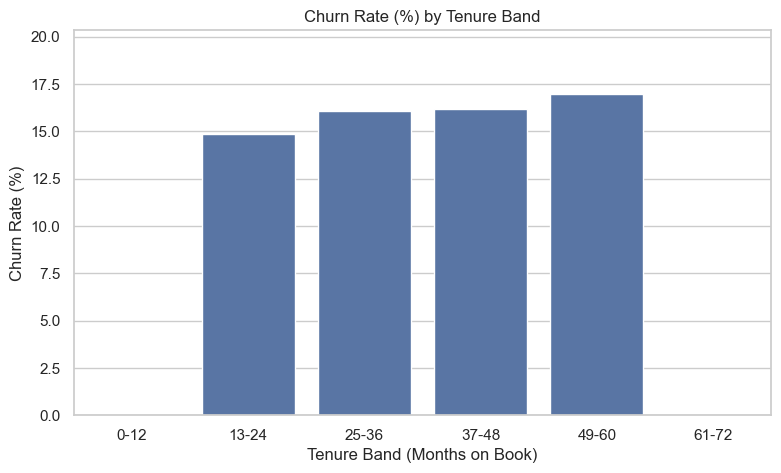

In [14]:
plt.figure(figsize=(9, 5))
sns.barplot(
    data=churn_by_tenure_band,
    x="TenureBand",
    y="churn_rate_pct"
)
plt.title("Churn Rate (%) by Tenure Band")
plt.xlabel("Tenure Band (Months on Book)")
plt.ylabel("Churn Rate (%)")
plt.ylim(0, churn_by_tenure_band["churn_rate_pct"].max() * 1.2)
plt.show()


### Evidence B — Churn Rate by Tenure Band

**What I expected:**  
Churn rates would be higher in early tenure bands and decline as customer tenure increases.

**What the data shows:**  
- Customers in the **13–24 month** tenure band exhibit the lowest churn rate (14.9%).
- Churn rates increase gradually across subsequent tenure bands:
  - 25–36 months: 16.1%
  - 37–48 months: 16.2%
  - 49–60 months: 17.0%
- No customers fall within the 0–12 or 61–72 month tenure bands in this dataset.

**Interpretation:**  
Contrary to the initial expectation, churn does not decrease with tenure.
Instead, churn rates show a modest upward trend as tenure increases,
suggesting that long-standing customers may also be at risk of attrition.


### Conclusion — Hypothesis 2

The results partially challenge Hypothesis 2.
While early-tenure customers (13–24 months) exhibit the lowest churn rates,
churn does not consistently decline with increasing tenure.
Instead, churn rates increase modestly among longer-tenured customers.

### Business Implications
- Retention strategies should not focus exclusively on early lifecycle customers.
- Long-tenured customers may experience disengagement, fatigue, or competitive switching,
  and should be included in ongoing retention monitoring.
- Tenure alone is not a sufficient predictor of churn and should be evaluated alongside
  engagement and behavioural indicators.

### Limitations
This analysis is descriptive and does not explain why churn increases among longer-tenured customers.
Additional variables such as satisfaction, pricing changes, or external competition
are not captured in the dataset.


----


# Hypothesis 3 

### Hypothesis 3 — Transaction Behaviour & Churn

### Business Question
Do customers with lower transaction activity churn more than customers who actively use their credit cards?

### Hypothesis
Customers with **lower transaction frequency** and **lower transaction value**
are more likely to churn than customers with higher transaction activity.

### Measures Used
- **Churn outcome:** `ChurnFlag` (1 = churned, 0 = existing)
- **Transaction frequency:** `TotalTransCt`
- **Transaction value:** `TotalTransAmt`
- *(Optional derived)* **Average transaction value:** `Avg_Transaction_Value`

### Analytical Approach
The hypothesis is evaluated using descriptive analytics and visualisation techniques:
1. Compare transaction **count distributions** between churned and existing customers.
2. Compare transaction **value distributions** between churned and existing customers.
3. Examine the relationship between transaction count and transaction amount,
   coloured by churn status to identify behavioural patterns.


## Evidence A: transaction count

In [15]:
trans_ct_summary = (
    df.groupby("ChurnFlag")["TotalTransCt"]
      .agg(count="count", mean="mean", median="median", min="min", max="max")
      .round(2)
)
trans_ct_summary


,count,mean,median,min,max
ChurnFlag,,,,,
0,8500,68.67,71.0,11,139
1,1627,44.93,43.0,10,94


## Plot 1: boxplot for transaction count

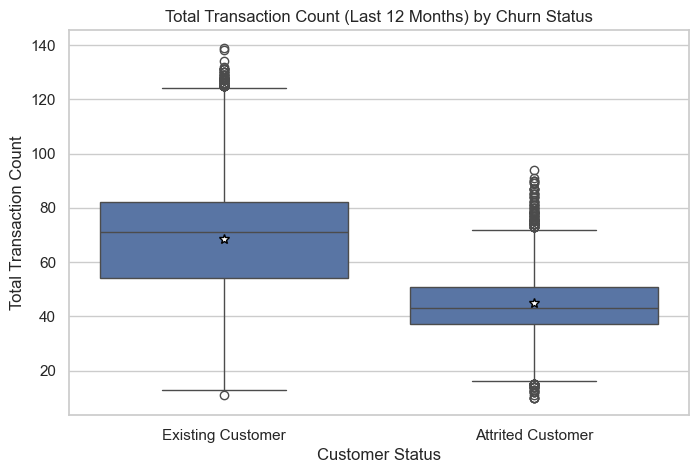

In [16]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df,
            x="AttritionFlag",
            y="TotalTransCt",
            showmeans=True,
            meanprops={
        "marker": "*",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": 7
    }
    )
plt.title("Total Transaction Count (Last 12 Months) by Churn Status")
plt.xlabel("Customer Status")
plt.ylabel("Total Transaction Count")
plt.show()


Mean transaction counts as an overlay to provide additional summary measures alongside the median, which would support stakeholder understanding!

### Evidence A — Transaction Amount vs Churn

**What I expected:**  
Customers who churn would exhibit lower total transaction amounts
than customers who remain active.

**What the data shows:**  
- Churned customers have a substantially lower average total transaction amount
  (mean = 3,095) compared to existing customers (mean = 4,655).
- The median transaction amount for churned customers (2,329)
  is considerably lower than that of existing customers (4,100).
- This indicates a clear separation in spending behaviour between the two groups.

**Interpretation:**  
Lower transaction value is strongly associated with churn,
suggesting that reduced card spending is a key behavioural signal of disengagement.


### Evidence B: transaction amount

In [17]:
trans_amt_summary = (
    df.groupby("AttritionFlag")["TotalTransAmt"]
      .agg(count="count", mean="mean", median="median", min="min", max="max")
      .round(2)
)
trans_amt_summary


,count,mean,median,min,max
AttritionFlag,,,,,
Attrited Customer,1627,3095.03,2329.0,510,10583
Existing Customer,8500,4654.66,4100.0,816,18484


Plot 2: boxplot for transaction amount 

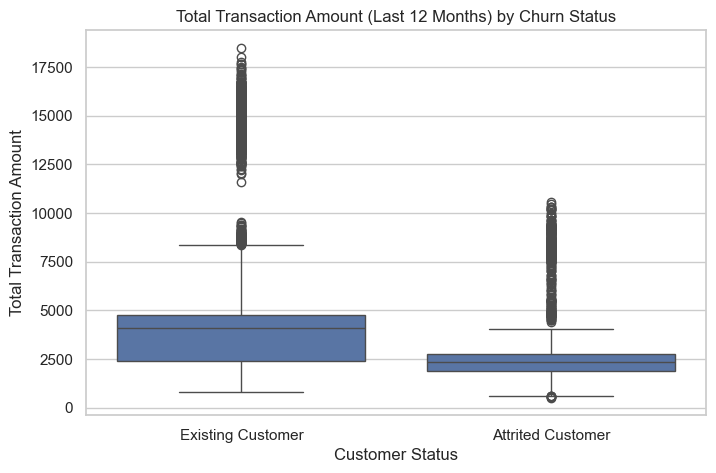

In [18]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="AttritionFlag", y="TotalTransAmt")
plt.title("Total Transaction Amount (Last 12 Months) by Churn Status")
plt.xlabel("Customer Status")
plt.ylabel("Total Transaction Amount")
plt.show()


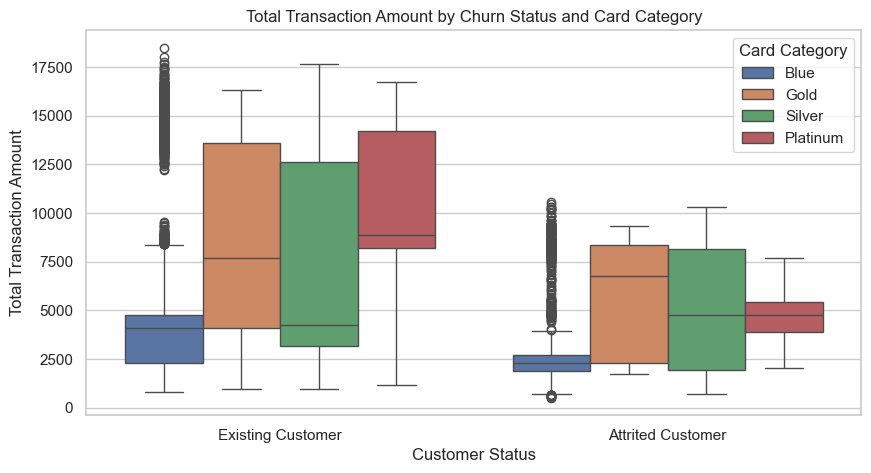

In [19]:
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df,
    x="AttritionFlag",
    y="TotalTransAmt",
    hue="CardCategory"
)
plt.title("Total Transaction Amount by Churn Status and Card Category")
plt.xlabel("Customer Status")
plt.ylabel("Total Transaction Amount")
plt.legend(title="Card Category")
plt.show()

### Supporting Analysis — Transaction Amount by Card Category

To further explore transaction behaviour, total transaction amounts were segmented
by card category and churn status.

**Key observations:**
- Across all card categories (Blue, Gold, Silver, Platinum),
  existing customers consistently exhibit higher transaction amounts
  than churned customers.
- While higher-tier cardholders (e.g. Platinum) show greater overall spend,
  the reduction in transaction amount among churned customers
  is evident across all tiers.
- This suggests that churn is associated with declining usage behaviour
  rather than card category alone.

**Interpretation:**  
Reduced transaction value is a consistent churn signal across product tiers,
indicating that behavioural engagement is a stronger indicator of churn
than card category in isolation.


### Evidence B — Transaction Count vs Churn

**What I expected:**  
Churned customers would make fewer transactions than existing customers.

**What the data shows:**  
- Existing customers make significantly more transactions on average
  (mean = 68.7) compared to churned customers (mean = 44.9).
- The median transaction count is notably higher for existing customers
  (71) than for churned customers (43).
- The distribution of transaction counts for churned customers
  is clearly shifted toward lower values.

**Interpretation:**  
Lower transaction frequency is strongly associated with churn,
reinforcing transaction count as a reliable indicator of customer engagement.


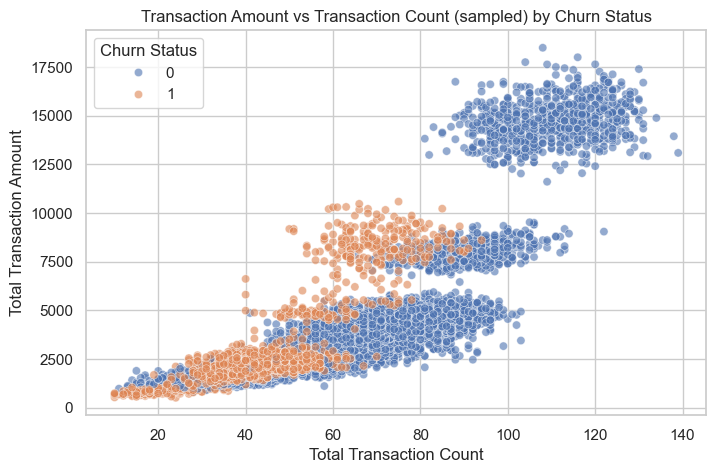

In [20]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x="TotalTransCt",
    y="TotalTransAmt",
    hue="ChurnFlag",
    alpha=0.6
)
plt.title("Transaction Amount vs Transaction Count (sampled) by Churn Status")
plt.xlabel("Total Transaction Count")
plt.ylabel("Total Transaction Amount")
plt.legend(title="Churn Status")
plt.show()


### Conclusion — Hypothesis 3

The evidence strongly supports Hypothesis 3.
Customers who churn exhibit both lower transaction frequency
and lower transaction value compared to customers who remain active.

Together, these findings indicate that declining card usage
is a key behavioural warning signal preceding customer churn.


### Business Implications
- Monitor customers with declining transaction counts or spend
  as part of an early churn detection strategy.
- Introduce targeted engagement initiatives such as:
  - rewards or cashback incentives,
  - personalised usage reminders,
  - spend-based promotions.
- Combine transaction behaviour with inactivity and relationship metrics
  to prioritise high-risk customers for retention efforts.


## Overall Conclusions

This analysis examined customer churn within a credit card portfolio using descriptive
analytics and visualisation techniques. Three hypotheses were tested to understand
how customer engagement, tenure, and transaction behaviour relate to churn.

### Summary of Findings

- **Hypothesis 1 (Engagement & Inactivity)** was strongly supported.  
  Customers who churn tend to be less engaged, exhibiting higher inactivity
  and holding fewer product relationships. Churn rates were highest among customers
  with one or two relationships and declined significantly as relationship count increased.

- **Hypothesis 2 (Tenure & Churn)** was partially challenged.  
  Contrary to expectations, churn did not consistently decrease with longer tenure.
  Instead, churn rates showed a modest increase among longer-tenured customers,
  suggesting that tenure alone is not a reliable indicator of retention risk and
  should be interpreted alongside behavioural engagement metrics.

- **Hypothesis 3 (Transaction Behaviour & Churn)** was strongly supported.  
  Churned customers consistently demonstrated lower transaction frequency and
  lower transaction value than existing customers. This pattern was evident across
  all card categories, indicating that declining usage behaviour is a key early
  warning signal for churn, regardless of product tier.

### Key Business Insights

Taken together, the findings indicate that **behavioural engagement** is a stronger
and more consistent indicator of churn risk than demographic or tenure-based factors.
Customers who reduce their card usage, become inactive, or maintain minimal product
relationships are significantly more likely to churn.

Importantly, even customers in higher-value segments (e.g. premium card categories
or long-tenured customers) are at risk when engagement declines. This highlights the
need for ongoing engagement monitoring rather than assuming loyalty based on tenure
or product tier alone.

### Recommendations

- Implement early-warning monitoring based on:
  - declining transaction counts or spend,
  - increasing inactivity,
  - low product relationship counts.
- Prioritise proactive engagement strategies for customers showing early signs
  of disengagement, regardless of tenure or card category.
- Combine multiple behavioural indicators into a simple churn-risk framework
  to support targeted retention initiatives.

### Limitations and Future Work

This project is based on descriptive analytics and does not establish causality.
Customer churn may also be influenced by factors not captured in the dataset,
such as customer satisfaction, pricing changes, competitive offers, or
macroeconomic conditions.

Future work could extend this analysis by incorporating predictive modelling,
time-series behaviour analysis, or additional customer experience data to further
enhance churn detection and prevention strategies.
